In [ ]:
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)

In [ ]:
train_data_file = 'data/train-*.csv'
valid_data_file = 'data/valid-*.csv'
test_data_file = 'data/test-*.csv'

## Steps to use the TF Estimator APIs - Extended

1. Define dataset metadata

2. Create TF feature columns based on metadata + **Extended Feature Columns**

3. Define data input function to populate the features from the data source + **Apply Feature Pre-processing**

4. Create experiment: Initialise the Estimator & Evaluation metric + **Wide & Deep Columns for the combined DNN model**

5. Run experiment: Supply train data, evaluation data, config, and params

6. Evaluate the trained model on the test set

<img src="images/exp2.png" width="800" hight="400">

## Define dataset metadata

In [ ]:
HEADER = ['pickup_datetime',
          'pickup_dayofweek',
          'pickup_hour',
          'pickup_longitude',
          'pickup_latitude',
          'dropoff_longitude',
          'dropoff_latitude', 
          'passenger_count',
          'fare_amount']


DEFAULTS = [['NULL'],['NULL'],[-1], [-74.0], [40.0], [-74.0], [40.7], [-1],[-.1]]

NUMERIC_FEATURE_NAMES = ['pickup_longitude', 
                         'pickup_latitude',
                         'dropoff_longitude', 
                         'dropoff_latitude', 
                         'passenger_count']

CATEGORICAL_FEATURE_NAMES_AND_VOCABULARY = {
    'pickup_dayofweek' :  ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    'pickup_hour': list(range(0,24))
}

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(CATEGORICAL_FEATURE_NAMES_AND_VOCABULARY.keys())

TARGET_NAME = 'fare_amount'

UNUSED_FEATURE_NAMES = set(HEADER) - set(FEATURE_NAMES) - set([TARGET_NAME])

print("Numeric features: {}".format(NUMERIC_FEATURE_NAMES))
print("Categorical features: {}".format(list(CATEGORICAL_FEATURE_NAMES_AND_VOCABULARY.keys())))
print("Target: {}".format(TARGET_NAME))
print("Unused features: {}".format(UNUSED_FEATURE_NAMES))

## Define input features + extensions!

In [ ]:
def extend_feature_columns(feature_columns, hparams):
    
    #bucketized 
    buckets = hparams.buckets
    lat_buckets = np.linspace(38.0, 42.0, buckets).tolist()
    lon_buckets = np.linspace(-76.0, -72.0, buckets).tolist()
    
    b_plat = tf.feature_column.bucketized_column(feature_columns[FEATURE_NAMES.index("pickup_latitude")], lat_buckets)
    b_dlat = tf.feature_column.bucketized_column(feature_columns[FEATURE_NAMES.index("dropoff_latitude")], lat_buckets)
    
    b_plon = tf.feature_column.bucketized_column(feature_columns[FEATURE_NAMES.index("pickup_longitude")], lon_buckets)
    b_dlon = tf.feature_column.bucketized_column(feature_columns[FEATURE_NAMES.index("dropoff_longitude")], lon_buckets)

    
    #feature crossing (interactions)
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], buckets**2)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], buckets**2)
    pd_pair = tf.feature_column.crossed_column([ploc, dloc], buckets ** 4)
    
    day_hr =  tf.feature_column.crossed_column([feature_columns[FEATURE_NAMES.index("pickup_hour")], 
                                                feature_columns[FEATURE_NAMES.index("pickup_dayofweek")]], 24*7)
    
    
    feature_columns = feature_columns + [b_plat,b_dlat,b_plon,dloc,pd_pair,day_hr]
    return feature_columns

In [ ]:
def create_feature_columns(hparams):

    numeric_columns = list(map(lambda feature_name: tf.feature_column.numeric_column(feature_name),
                               NUMERIC_FEATURE_NAMES))

    categorical_columns = list(map(lambda item:
                                   tf.feature_column.categorical_column_with_vocabulary_list(item[0],item[1]),
                                   CATEGORICAL_FEATURE_NAMES_AND_VOCABULARY.items())
                               )

    feature_columns = numeric_columns + categorical_columns

    return extend_feature_columns(feature_columns,hparams)

# Test create_feature_columns
hparams = tf.contrib.training.HParams(buckets=10)
feature_columns = create_feature_columns(hparams) 
column_names = list(map(lambda column: column.name,feature_columns))
print(column_names)

## Feature pre-processing logic

In [ ]:
def process_features(features,params):

    lat1 = features['pickup_latitude']
    lat2 = features['dropoff_latitude']
    latdiff = (lat1 - lat2) #identify west <-> east
        
    lon1 = features['pickup_longitude']
    lon2 = features['dropoff_longitude']
    londiff = (lon1 - lon2) #identify north <-> south

    features['longitude_diff'] = latdiff
    features['latitude_diff'] = londiff
    
    #euclidean distance
    dist = tf.sqrt(latdiff*latdiff + londiff*londiff)
    features['euclidean_dist'] = dist
    
    return features 

## Define a (scalable) data input function


There are couple extensions to this function:


* The function can read from multiple csv files in chuncks, hence, the data does not have to fit in the memory.
* Incorporate epochs and batch size.
* The function applies pre-processing to the features.

In [ ]:
def csv_input_fn(filename, hparams,num_epochs=None, batch_size=512):
    
    
    input_file_names = tf.train.match_filenames_once(filename)
 
    
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=False)
    
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)

    value_column = tf.expand_dims(value, -1)
    columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
    
    features = dict(zip(HEADER, columns))
    
    target = features.pop(TARGET_NAME)
    
    for feature in UNUSED_FEATURE_NAMES:
        features.pop(feature)
    
    return process_features(features, hparams), target


features, target = csv_input_fn(train_data_file,hparams)
feature_colum_names = list(features.keys())
print(feature_colum_names)
print(target)

## Define the evaluation metric

In [ ]:
evaluation_metrics={
    'rmse': tf.contrib.learn.MetricSpec(metric_fn=tf.metrics.root_mean_squared_error)
    }

def print_evaluation(estimator,hparams):
    
    tf.logging.set_verbosity(tf.logging.ERROR)
    train_metric = estimator.evaluate(input_fn = lambda: csv_input_fn(train_data_file,hparams), 
                                        steps=1, 
                                        metrics = evaluation_metrics)

    valid_metric = estimator.evaluate(input_fn = lambda: csv_input_fn(valid_data_file,hparams), 
                                        steps=1, 
                                        metrics = evaluation_metrics)

    test_metric = estimator.evaluate(input_fn = lambda: csv_input_fn(test_data_file,hparams), 
                                       steps=1, 
                                       metrics = evaluation_metrics)

    print("")
    print("train metric:{}".format(train_metric))
    print("valid metric:{}".format(valid_metric))
    print("test metric:{}".format(test_metric))

## Defining the wide and deep features
As we are going to use a Wide & Deep Combined NN, we need to define the wide & deep features

In [ ]:
def get_deep_and_wide_columns(feature_columns, embedding_size):

    dense_columns = list(filter(lambda item: "Numeric" in str(item.__class__), feature_columns))
    sparse_columns = list(filter(lambda item: "Numeric" not in str(item.__class__), feature_columns))

    embedding_columns =  list(map(lambda sparse_column: 
                                  tf.feature_column.embedding_column(sparse_column,dimension=embedding_size)
                                  ,sparse_columns))

    deep_columns = dense_columns + embedding_columns
    wide_columns = sparse_columns

    return deep_columns, wide_columns

  
hparams = tf.contrib.training.HParams(embedding_size=10)
dense_columns, sparse_columns = get_deep_and_wide_columns(feature_columns,hparams.embedding_size)

dense_column_names = list(map(lambda column: column.name,dense_columns))
print(dense_column_names)
print("")
sparse_column_names = list(map(lambda column: column.name,sparse_columns))
print(sparse_column_names)

## Create and experiement with deep and wide combined NN estimator

In [ ]:
def experiment_dnn_combined_regression(run_config,hparams):

    dnn_optimizer = tf.train.AdamOptimizer()
    
    dnn_combined_estimator = tf.contrib.learn.DNNLinearCombinedRegressor(
            linear_feature_columns = sparse_columns,
            dnn_feature_columns = dense_columns,
            dnn_hidden_units=hparams.hidden_units,
            dnn_activation_fn=tf.nn.relu,
            dnn_optimizer=dnn_optimizer,
            config = run_config,
            fix_global_step_increment_bug=True
            )
    
    experiment =  tf.contrib.learn.Experiment(estimator = dnn_combined_estimator, 
                                     train_steps = hparams.training_steps,
                                     train_input_fn = lambda: csv_input_fn(train_data_file,hparams,
                                                                           num_epochs=hparams.num_epochs,
                                                                           batch_size = hparams.batch_size
                                                                          ), 
                                     eval_input_fn =lambda: csv_input_fn(valid_data_file,hparams),
                                     eval_metrics = evaluation_metrics
                                    )
    return experiment



## Set params and run experiemnt - DNN Combined

In [ ]:
# Set params
hparams  = tf.contrib.training.HParams(training_steps=None,
                                       num_epochs = 10000, 
                                       batch_size = 512, 
                                       embedding_size = 8,
                                       buckets = 8,
                                       hidden_units=[64, 32, 16])


model_dir = "trained_models/dnn_combined_regression_model"
#shutil.rmtree(model_dir, ignore_errors=True)

run_config = tf.contrib.learn.RunConfig(
    model_dir=model_dir
)

# Run the experiment
# tf.logging.set_verbosity(tf.logging.WARN)
# tf.contrib.learn.learn_runner.run(experiment_fn = experiment_dnn_combined_regression, 
#                                run_config = run_config,
#                                schedule="train_and_evaluate",
#                                hparams=hparams)

## Evaluate trained model - DNN Combined

In [ ]:
dnn_combined_model = tf.contrib.learn.DNNLinearCombinedRegressor(
            linear_feature_columns = sparse_columns,
            dnn_feature_columns = dense_columns,
            dnn_hidden_units=hparams.hidden_units,
            config = run_config
            )

print_evaluation(dnn_combined_model,hparams)

## Results so far...

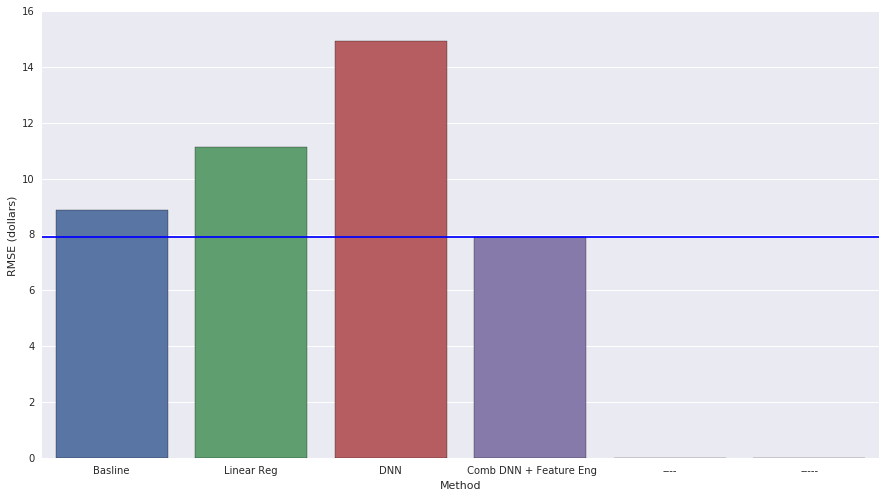

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({
              'Method' : pd.Series(['Basline', 'Linear Reg', 'DNN', ' Comb DNN + Feature Eng', '----', '-----']),
              'RMSE': pd.Series([8.89, 11.15, 14.94, 7.9, 0.0, .0]) })

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df, x='Method', y='RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Method')
plt.plot(np.linspace(-20,120,1000), [7.9]*1000, 'b');